In [2]:
# =========== IMPORT LIBRARIES ===========

#install.packages(c("MCMCpack","ggplot2","gridExtra","corrplot","caret","rstanarm"))
library(caret)
library(MCMCpack)
library(rstanarm)
library(GGally)
library(ggplot2)
library(gridExtra)
library(corrplot)
library(reshape2)
library(RColorBrewer)
library(bayesplot)
library(cowplot)
library(dplyr)
library(glmnet)
library(plotmo)
library(BayesVarSel)

Loading required package: ggplot2

Loading required package: lattice

Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2024 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Loading required package: Rcpp

This is rstanarm version 2.32.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())


Attaching package: 'rstanarm'


The following objects are masked from 'package:caret':

    compare_models, R2


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

corrplot 0.92 loaded

This is bayesplot version 1.11.1

-

In [3]:
# =========== READ DATA ===========
housing <- read.csv("data/housing.csv")

# convert variables
housing$ocean_proximity = factor(housing$ocean_proximity)
levels(housing$ocean_proximity)

# look at the data
head(housing)
dim(housing)
summary(housing)

[1] "<1H OCEAN"  "INLAND"     "ISLAND"     "NEAR BAY"   "NEAR OCEAN"

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


[1] 20640    10

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

No id variables; using all as measure variables



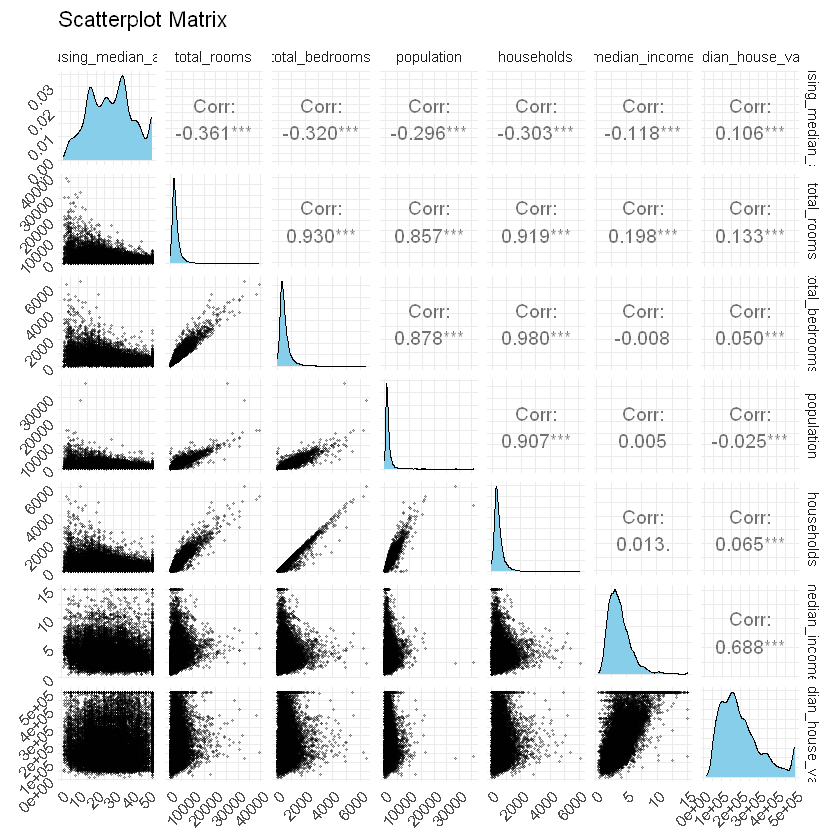

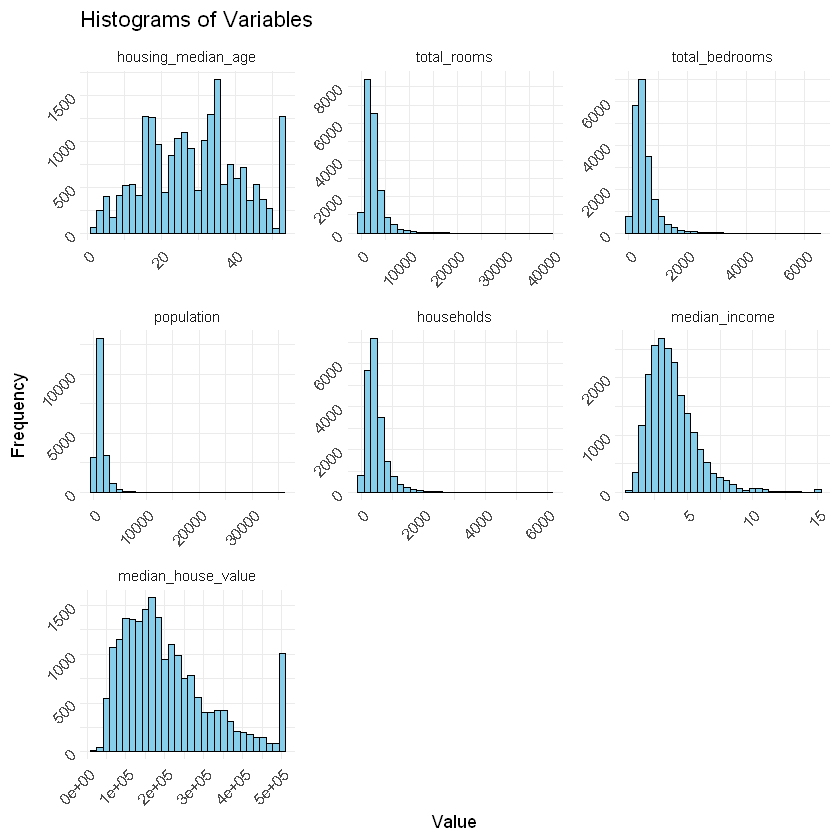

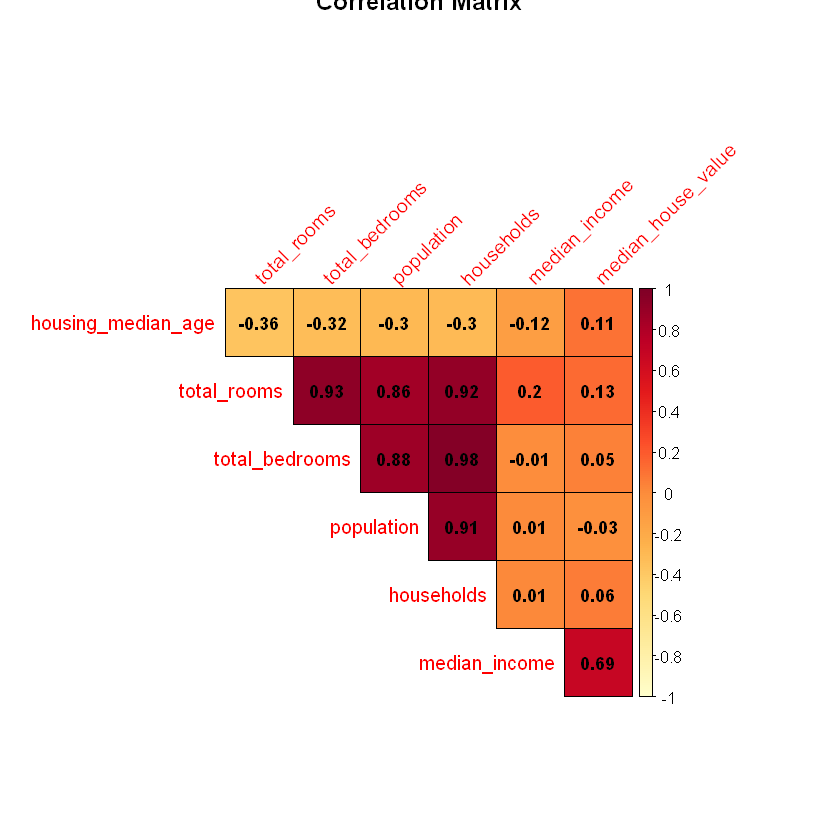

In [4]:
# =========== EXPLORATORY ANALYSIS ===========
# DROP NA (we should maybe interpolate :) )
housing <- na.omit(housing)

# SCATTERPLOT MATRIX
ggpairs(housing[,3:9], 
        title = "Scatterplot Matrix",
        upper = list(continuous = wrap("cor", size = 4)),
        lower = list(continuous = wrap("points", alpha = 0.3, size = 0.5)),
        diag = list(continuous = wrap("densityDiag", fill = "skyblue"))) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(angle = 45, hjust = 1))

# HISTOGRAMS
housing_long <- melt(housing[,3:9])
ggplot(housing_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "black") +
  facet_wrap(~ variable, scales = "free") +
  labs(title = "Histograms of Variables", x = "Value", y = "Frequency") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text.y = element_text(angle = 45, hjust = 1))

# CORRELATION MATRIX
# Create the correlation matrix
cor_matrix <- cor(housing[,3:9])

# Plot the correlation matrix
corrplot(cor_matrix, method = "color", 
         col = colorRampPalette(brewer.pal(9, "YlOrRd"))(200), 
         insig = "blank", type = "upper", 
         addCoef.col = "black", number.cex = 0.9, outline = TRUE, diag = FALSE,
         tl.srt = 45,  # Rotate text labels
         title = "Correlation Matrix")


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 17 rows containing missing values or values outside the scale range
(`geom_smooth()`)."
Warning message in max(ids, na.rm = TRUE):
"ningun argumento finito para max; retornando -Inf"


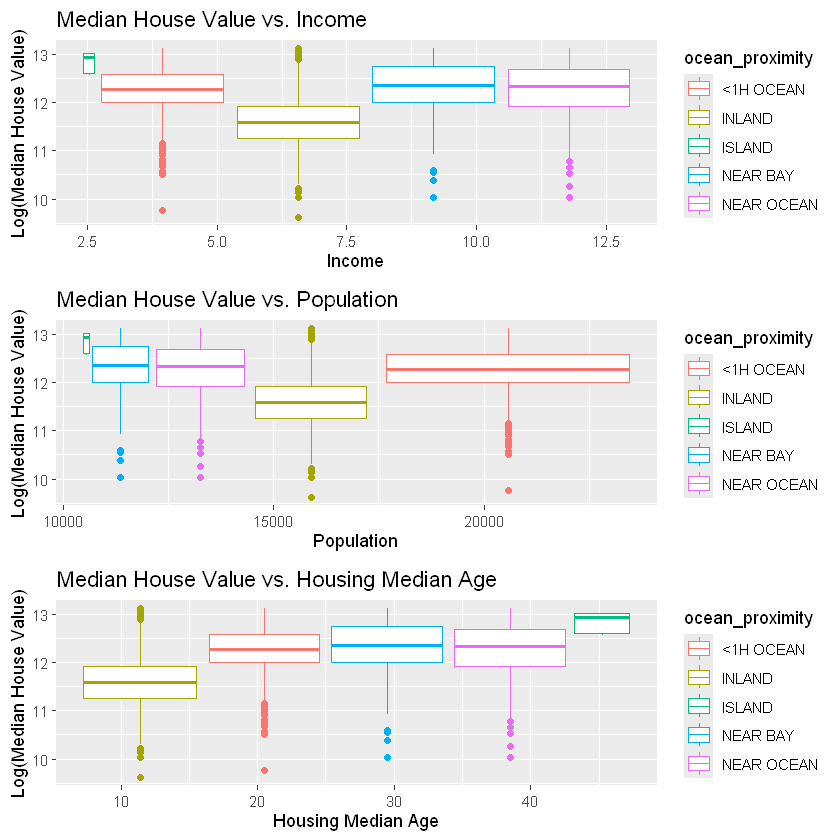

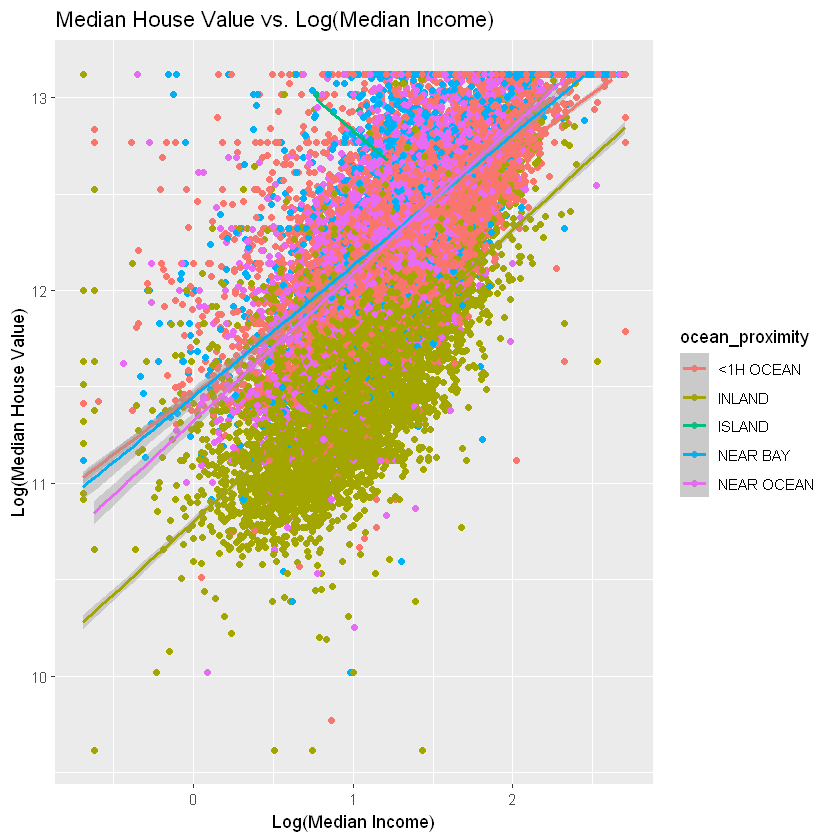

In [5]:
# Create the first plot
plot1 <- ggplot(data = housing, aes(x = median_income, y = log(median_house_value), color = ocean_proximity)) +
  geom_boxplot() +
  labs(title = "Median House Value vs. Income", x = "Income", y = "Log(Median House Value)")

# Create the second plot
plot2 <- ggplot(data = housing, aes(x = population, y = log(median_house_value), color = ocean_proximity)) +
  geom_boxplot() +
  labs(title = "Median House Value vs. Population", x = "Population", y = "Log(Median House Value)")

# Create the third plot
plot3 <- ggplot(data = housing, aes(x = housing_median_age, y = log(median_house_value), color = ocean_proximity)) +
  geom_boxplot() +
  labs(title = "Median House Value vs. Housing Median Age", x = "Housing Median Age", y = "Log(Median House Value)")

# Arrange plots next to each other
plot_grid(plot1, plot2, plot3, ncol = 1)

ggplot(data = housing, aes(x = log(median_income), y = log(median_house_value), color = ocean_proximity)) +
  geom_point() +
  geom_smooth(method = "lm") +
  ylim(c(min(log(housing$median_house_value)), max(log(housing$median_house_value)))) +
  labs(title = "Median House Value vs. Log(Median Income)", x = "Log(Median Income)", y = "Log(Median House Value)")


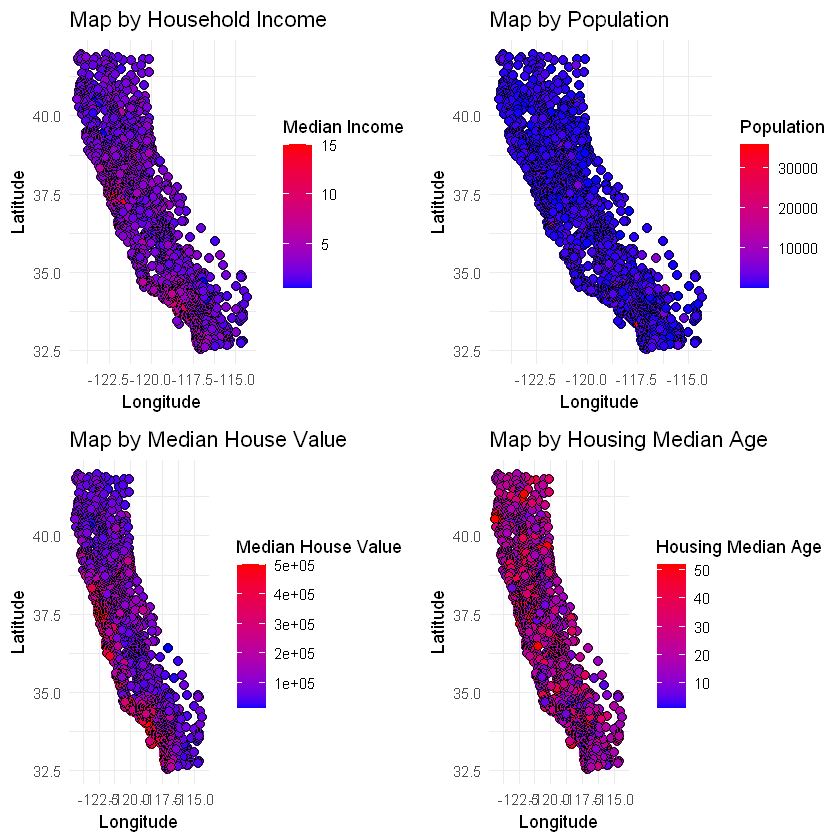

In [6]:
# =========== SPATIAL ANALYSIS ===========
# Plot 1: Household Income
plot_income <- ggplot(housing, aes(x = longitude, y = latitude, fill = median_income)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Household Income", x = "Longitude", y = "Latitude", fill = "Median Income") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Plot 2: Population
plot_population <- ggplot(housing, aes(x = longitude, y = latitude, fill = population)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Population", x = "Longitude", y = "Latitude", fill = "Population") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Plot 3: Median House Value
plot_house_value <- ggplot(housing, aes(x = longitude, y = latitude, fill = median_house_value)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Median House Value", x = "Longitude", y = "Latitude", fill = "Median House Value") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Plot 4: Housing Median Age
plot_housing_age <- ggplot(housing, aes(x = longitude, y = latitude, fill = housing_median_age)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Housing Median Age", x = "Longitude", y = "Latitude", fill = "Housing Median Age") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Combine plots into a 2x2 grid
grid.arrange(plot_income, plot_population, plot_house_value, plot_housing_age, ncol = 2)


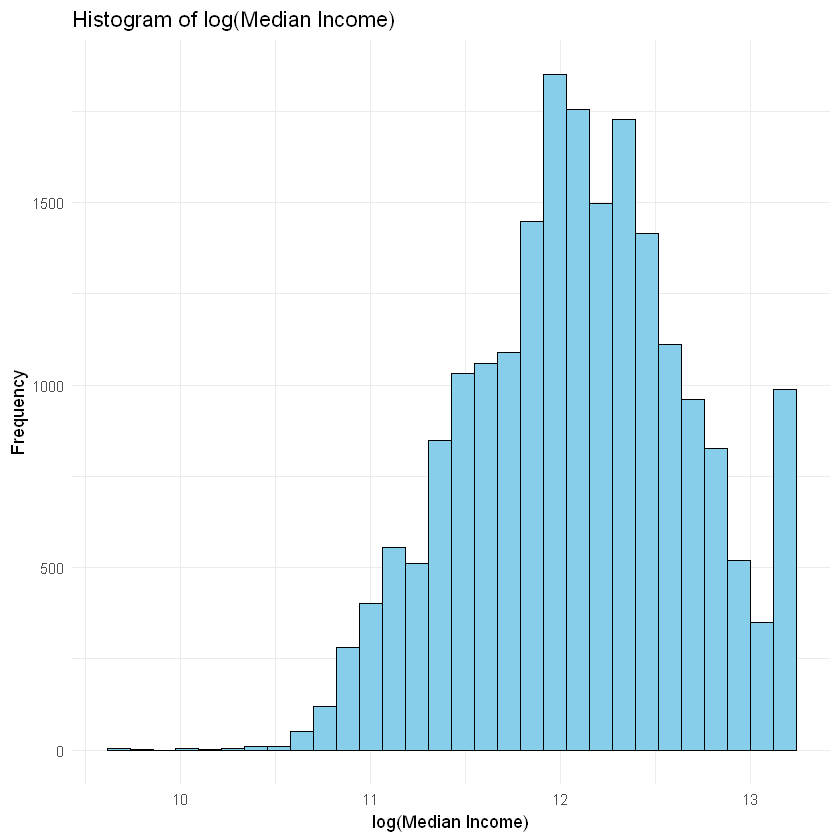

In [7]:
# =========== LOG TRANSFORMATION ===========
housing$ln_median_house_value <- log(housing$median_house_value) #to ensure better numerical accuracy

# Plot histogram with ggplot2
ggplot(housing, aes(x = ln_median_house_value)) +
  geom_histogram(fill = "skyblue", color = "black", bins = 30) +
  labs(title = "Histogram of log(Median Income)", x = "log(Median Income)", y = "Frequency") +
  theme_minimal()

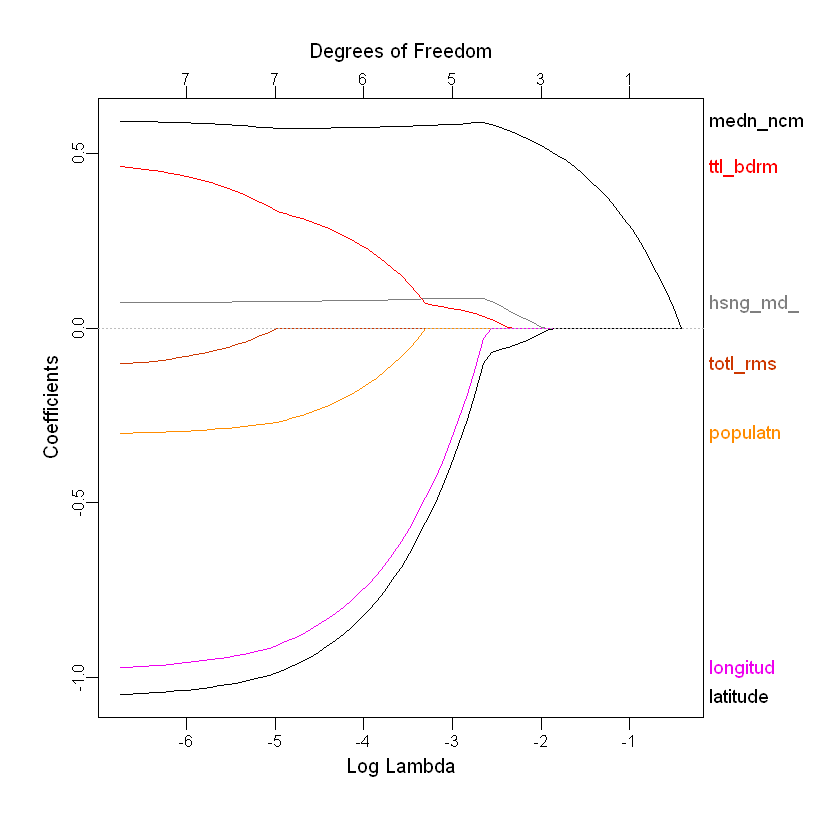

In [8]:
# Lasso regression 
houseprice_scaled <- mutate_if(housing, is.numeric, list(~scale(.) %>% as.vector))
response = houseprice_scaled$ln_median_house_value
obs = houseprice_scaled[,c("total_rooms","median_income","housing_median_age","population","total_bedrooms","longitude","latitude")]

ridge_regression <- glmnet(y=data.matrix(response), x=data.matrix(obs), alpha = 1) 
plot_glmnet(ridge_regression, xvar = "lambda", label = TRUE)

In [9]:
# brm.1 <- brm(log(price) ~ log(carat), 
             
#              brmsfamily("gaussian"), 
     
#              data = na.omit(diamonds.train), 
             
#              chains = 4, #specify the number of Markov chains
             
#              cores = getOption("mc.cores", 1),
             
#              iter = 3000, warmup = 1500, thin = 5,
             
#              prior =  c(prior(normal(0, 3), "b"), # set normal prior on regression coefficients (mean of 0, location of 3)
                        
#                         prior(normal(0, 3), "Intercept"))) # set normal prior on intercept (mean of 0, location of 3)

In [10]:
# =========== TRAIN/TEST SPLIT ===========

# set seed to reproduce results
set.seed(43)  
trainIndex <- createDataPartition(housing$ln_median_house_value, p = 0.7, list = FALSE)
train_dataset <- data[trainIndex, ]
test_dataset <- data[-trainIndex, ]

ERROR: Error in data[trainIndex, ]: objeto de tipo 'closure' no es subconjunto



Call:
lm(formula = ln_median_house_value ~ ., data = housing)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.55012 -0.07203  0.04331  0.09764  0.47504 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                7.197e+00  2.089e-01  34.453  < 2e-16 ***
longitude                 -4.930e-02  2.422e-03 -20.358  < 2e-16 ***
latitude                  -5.035e-02  2.383e-03 -21.126  < 2e-16 ***
housing_median_age        -1.994e-03  1.040e-04 -19.175  < 2e-16 ***
total_rooms                1.183e-05  1.851e-06   6.388 1.71e-10 ***
total_bedrooms            -3.634e-05  1.613e-05  -2.253   0.0243 *  
population                -1.367e-05  2.589e-06  -5.280 1.30e-07 ***
households                 4.471e-05  1.742e-05   2.566   0.0103 *  
median_income              4.532e-03  1.017e-03   4.455 8.45e-06 ***
median_house_value         4.190e-06  1.635e-08 256.330  < 2e-16 ***
ocean_proximityINLAND     -1.435e-01  4.124e-03 -34.791  < 

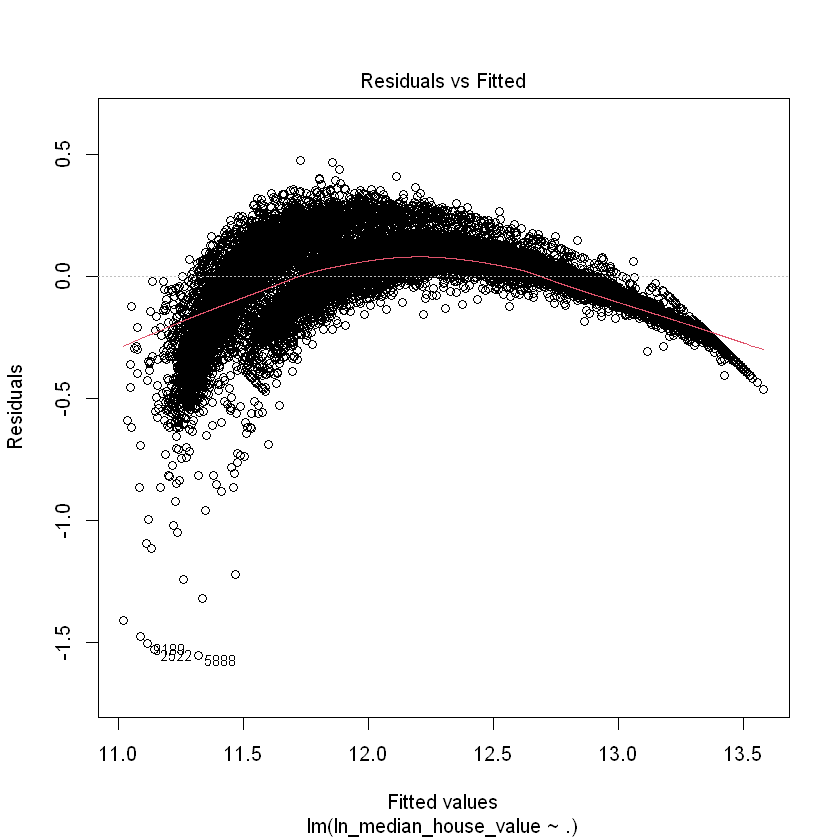

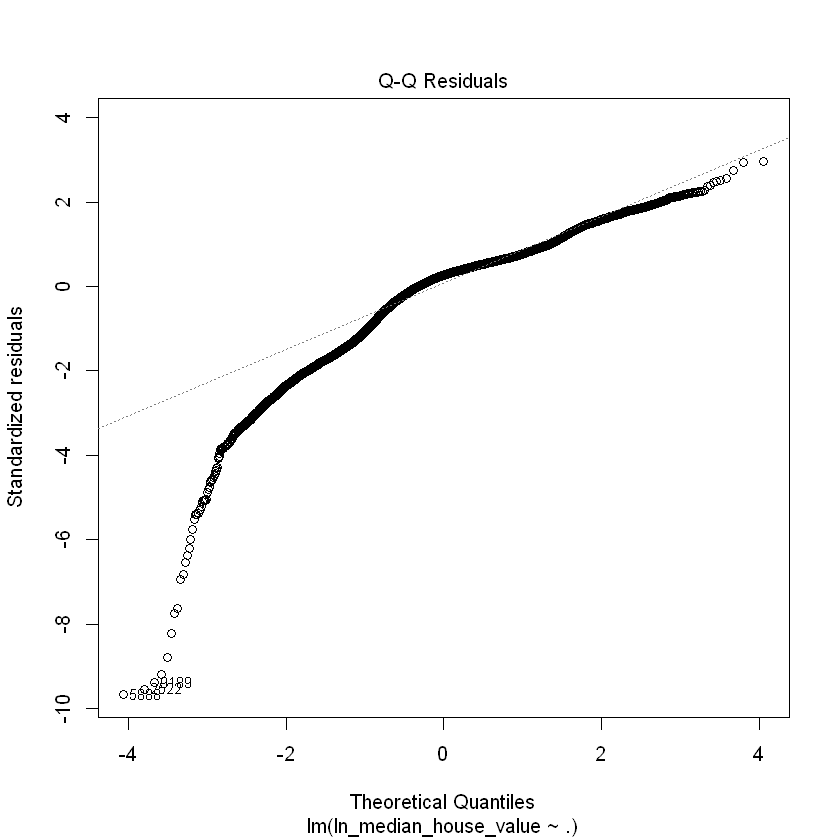

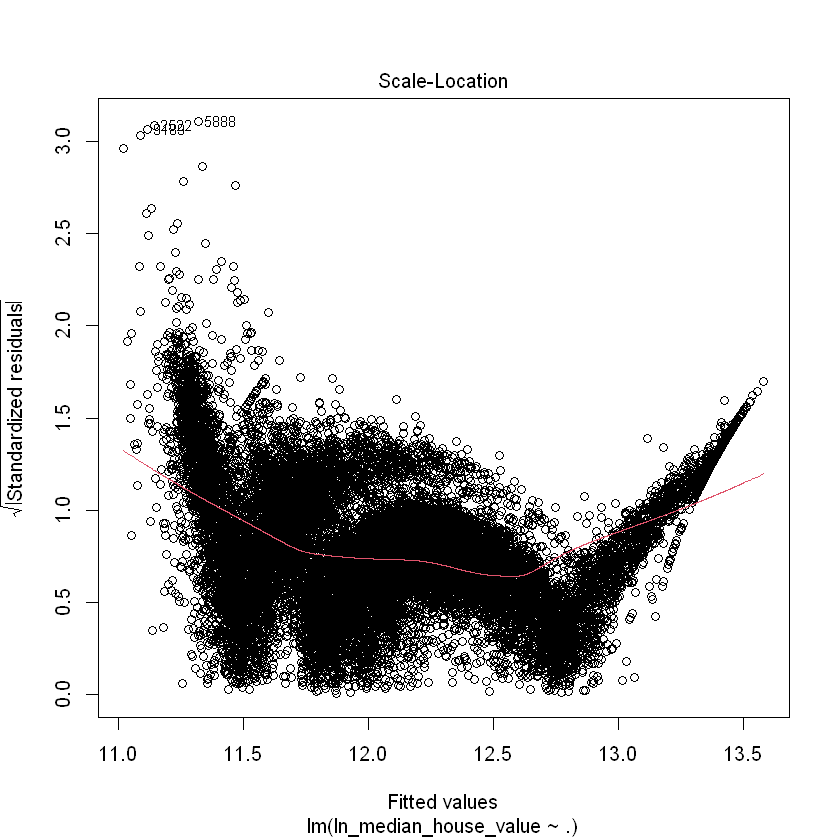

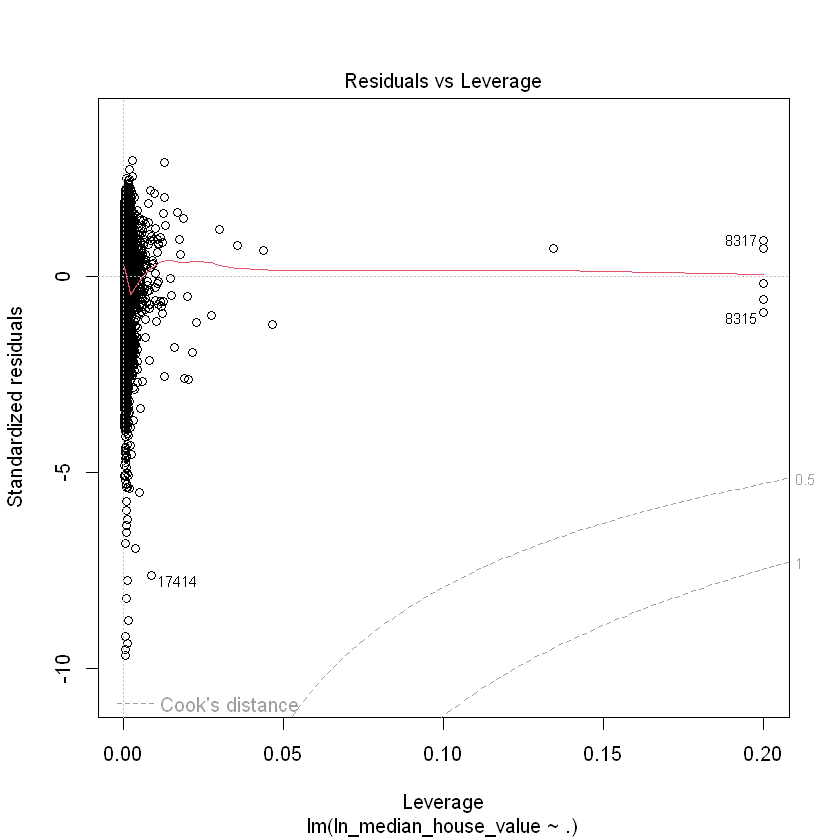

In [11]:
# =========== LINEAR REGRESSION ===========
m1 <- lm(ln_median_house_value ~ ., data = housing)
summary(m1)
plot(m1)

# !!!!!! The diagnostic plots show any significant problems with the model fit !!!!!!

In [12]:
V<-vcov(m1)
round(V,6)

,(Intercept),longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximityINLAND,ocean_proximityISLAND,ocean_proximityNEAR BAY,ocean_proximityNEAR OCEAN
(Intercept),0.043640,0.000503,0.000461,1e-06,0,0,0,0,-6e-06,0,-0.000472,0.000271,0.000205,1.6e-04
longitude,0.000503,0.000006,0.000006,0e+00,0,0,0,0,0e+00,0,-0.000006,0.000003,0.000002,2.0e-06
latitude,0.000461,0.000006,0.000006,0e+00,0,0,0,0,0e+00,0,-0.000006,0.000004,0.000000,2.0e-06
housing_median_age,0.000001,0.000000,0.000000,0e+00,0,0,0,0,0e+00,0,0.000000,0.000000,0.000000,0.0e+00
total_rooms,0.000000,0.000000,0.000000,0e+00,0,0,0,0,0e+00,0,0.000000,0.000000,0.000000,0.0e+00
total_bedrooms,0.000000,0.000000,0.000000,0e+00,0,0,0,0,0e+00,0,0.000000,0.000000,0.000000,0.0e+00
population,0.000000,0.000000,0.000000,0e+00,0,0,0,0,0e+00,0,0.000000,0.000000,0.000000,0.0e+00
households,0.000000,0.000000,0.000000,0e+00,0,0,0,0,0e+00,0,0.000000,0.000000,0.000000,0.0e+00
median_income,-0.000006,0.000000,0.000000,0e+00,0,0,0,0,1e-06,0,0.000000,0.000002,0.000000,0.0e+00
median_house_value,0.000000,0.000000,0.000000,0e+00,0,0,0,0,0e+00,0,0.000000,0.000000,0.000000,0.0e+00


In [13]:
X.gpa<-model.matrix(m1)
kappa(X.gpa)


[1] 34224099

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ln_median_house_value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,13.02276
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,12.78968
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,12.77167
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY,12.74052
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY,12.74315
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY,12.50507
7,-122.25,37.84,52,2535,489,1094,514,3.6591,299200,NEAR BAY,12.60887
8,-122.25,37.84,52,3104,687,1157,647,3.1200,241400,NEAR BAY,12.39421
9,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,12.33138


In [14]:
housing$ocean_proximity <- as.factor(housing$ocean_proximity)

housing$ocean_proximity <- as.integer(housing$ocean_proximity)


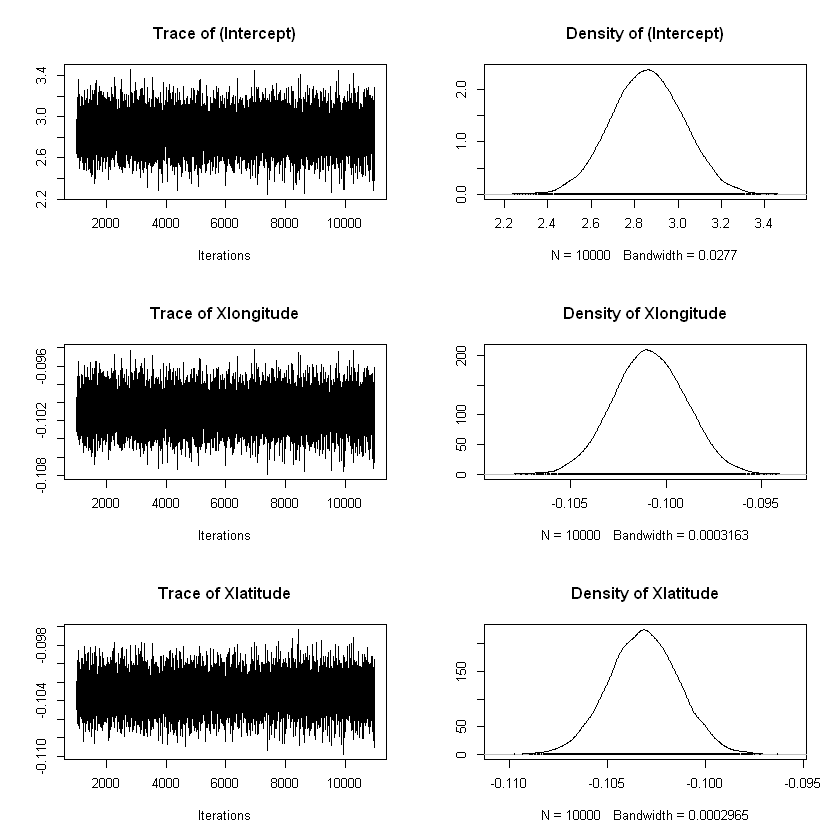

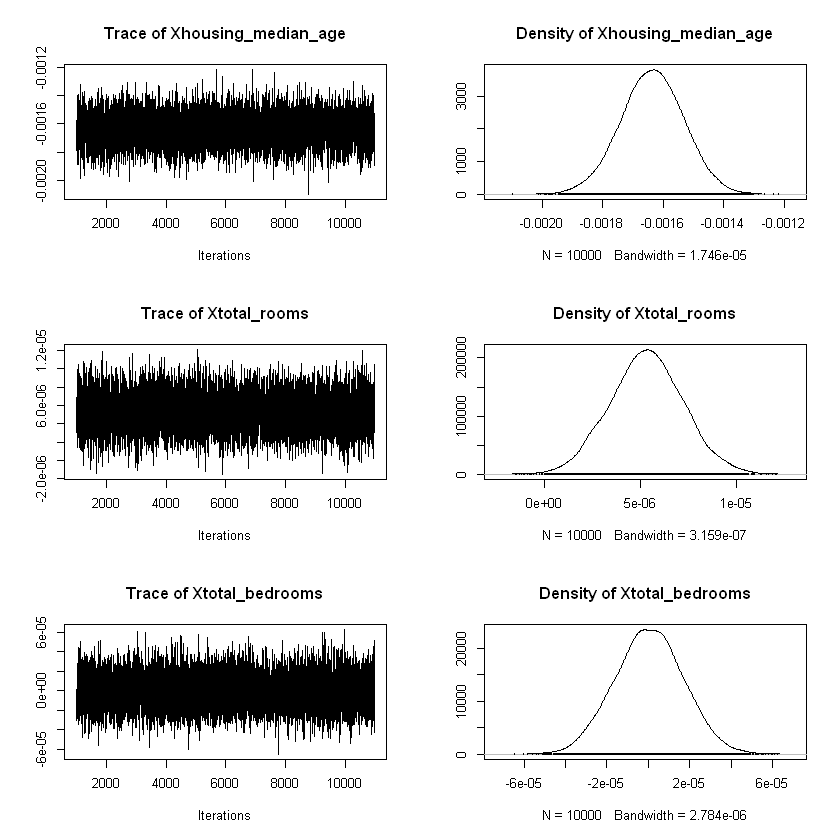

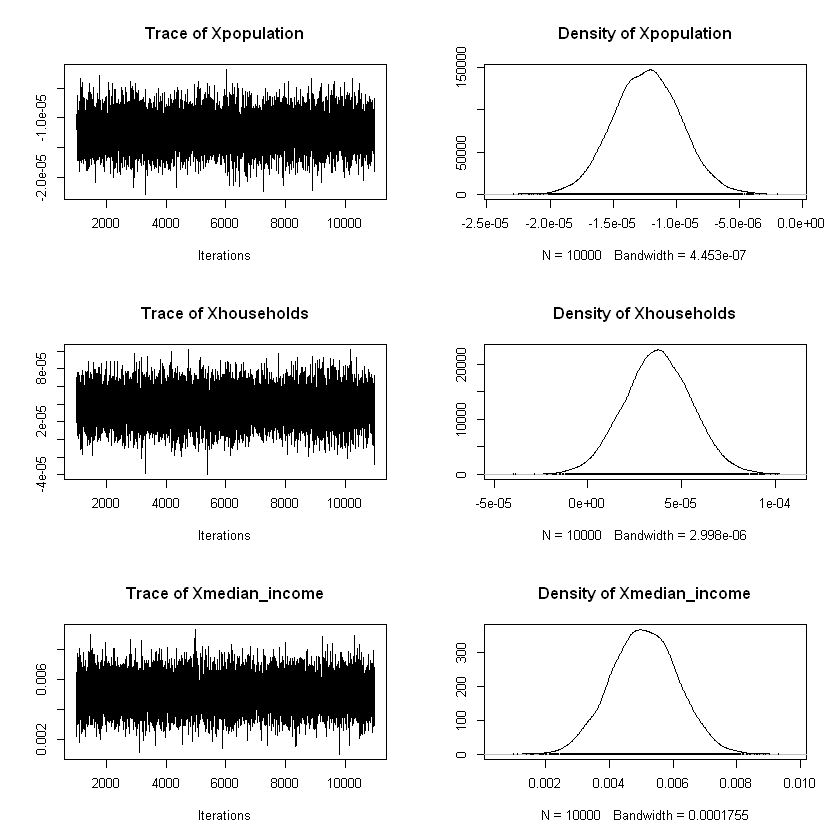

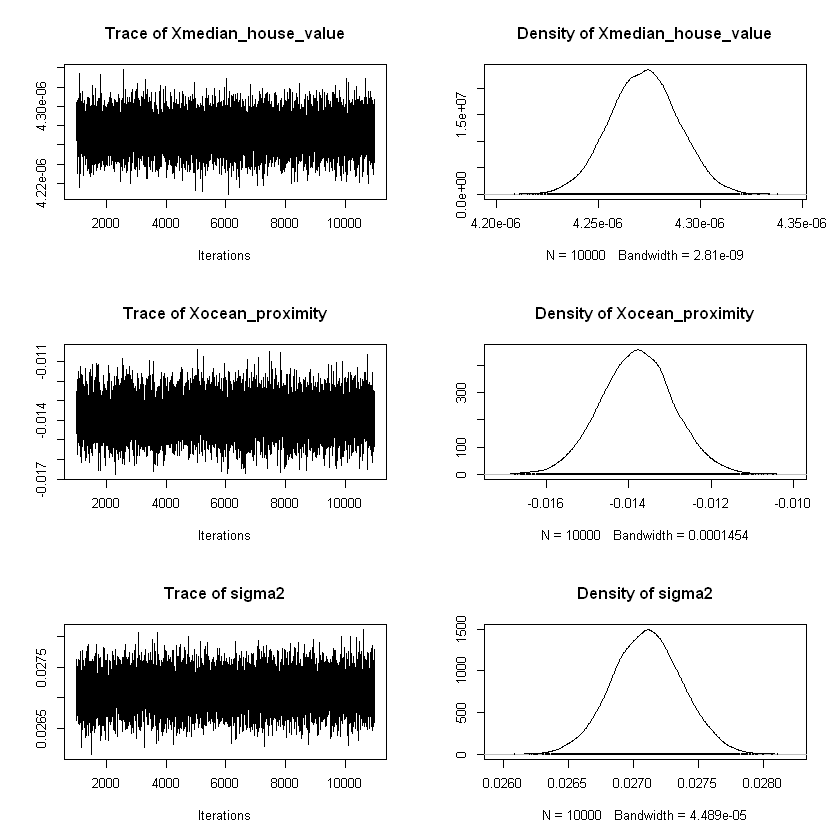

In [15]:

X <- as.matrix(housing[,c('longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity')])
post.reg1 <- MCMCregress(ln_median_house_value ~ X, data = housing,  seed = 1234567)  
plot(post.reg1)  ## trace plots and kernel density plots

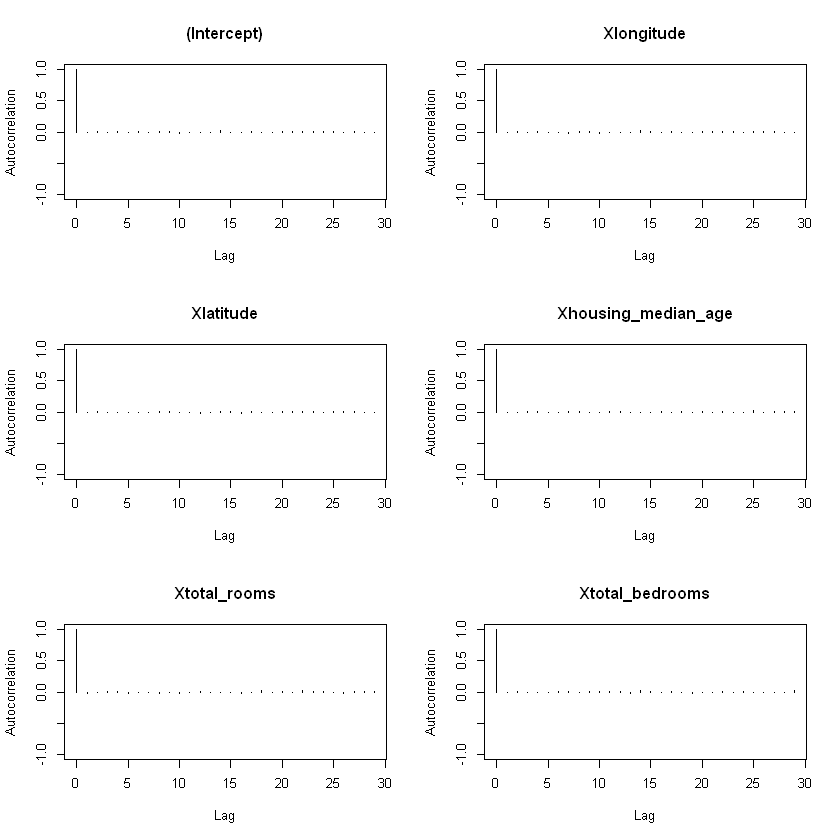

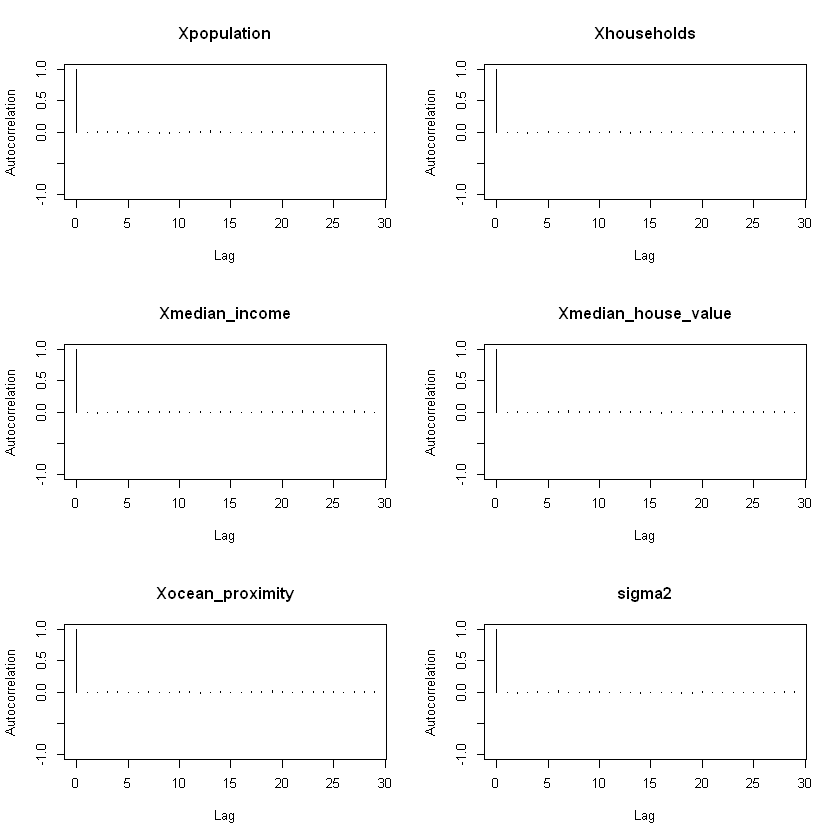

In [16]:
autocorr.plot(post.reg1) 


In [17]:
effectiveSize(post.reg1)

(Intercept)          Xlongitude           Xlatitude Xhousing_median_age 
           10000.00            10000.00            10000.00            10000.00 
       Xtotal_rooms     Xtotal_bedrooms         Xpopulation         Xhouseholds 
           10390.43            10292.18            10000.00            10000.00 
     Xmedian_income Xmedian_house_value    Xocean_proximity              sigma2 
           10410.32            10000.00            10000.00            10728.70

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ln_median_house_value
longitude,1.00000000,-0.92461611,-0.10935655,0.04548017,0.06960802,0.100270301,0.05651277,-0.015550150,-0.04539822,-0.28953010,-0.02285441
latitude,-0.92461611,1.00000000,0.01189907,-0.03666681,-0.06698283,-0.108997344,-0.07177419,-0.079626319,-0.14463821,0.20080107,-0.19277030
housing_median_age,-0.10935655,0.01189907,1.00000000,-0.36062830,-0.32045104,-0.295787297,-0.30276797,-0.118277723,0.10643205,0.11233014,0.07654991
total_rooms,0.04548017,-0.03666681,-0.36062830,1.00000000,0.93037950,0.857281251,0.91899153,0.197881519,0.13329413,-0.01536317,0.15328622
total_bedrooms,0.06960802,-0.06698283,-0.32045104,0.93037950,1.00000000,0.877746743,0.97972827,-0.007722850,0.04968618,-0.01476794,0.07866972
population,0.10027030,-0.10899734,-0.29578730,0.85728125,0.87774674,1.000000000,0.90718590,0.005086624,-0.02529973,-0.06962967,0.01393372
households,0.05651277,-0.07177419,-0.30276797,0.91899153,0.97972827,0.907185900,1.00000000,0.013433892,0.06489355,-0.01825061,0.09773782
median_income,-0.01555015,-0.07962632,-0.11827772,0.19788152,-0.00772285,0.005086624,0.01343389,1.000000000,0.68835548,-0.01467859,0.65881226
median_house_value,-0.04539822,-0.14463821,0.10643205,0.13329413,0.04968618,-0.025299732,0.06489355,0.688355475,1.00000000,0.08048786,0.94862413
ocean_proximity,-0.28953010,0.20080107,0.11233014,-0.01536317,-0.01476794,-0.069629667,-0.01825061,-0.014678594,0.08048786,1.00000000,0.05698874


In [18]:
post.reg2 <- MCMCregress(ln_median_house_value ~ X, data = housing,  seed = 121234)  

# do a few more (uncomment and complete the below, changing the seed each time)
post.reg3 <- MCMCregress(ln_median_house_value ~ X, data = housing,  seed = 131313)  
post.reg4 <- MCMCregress(ln_median_house_value ~ X, data = housing,  seed = 13131313)  
post.reg5 <- MCMCregress(ln_median_house_value ~ X, data = housing,  seed = 1313131313)  

postreg.list <- mcmc.list(post.reg1,post.reg2,post.reg3,post.reg4,post.reg5) # add the others here! 
gelman.diag(postreg.list)

Potential scale reduction factors:

                    Point est. Upper C.I.
(Intercept)                  1          1
Xlongitude                   1          1
Xlatitude                    1          1
Xhousing_median_age          1          1
Xtotal_rooms                 1          1
Xtotal_bedrooms              1          1
Xpopulation                  1          1
Xhouseholds                  1          1
Xmedian_income               1          1
Xmedian_house_value          1          1
Xocean_proximity             1          1
sigma2                       1          1

Multivariate psrf

1

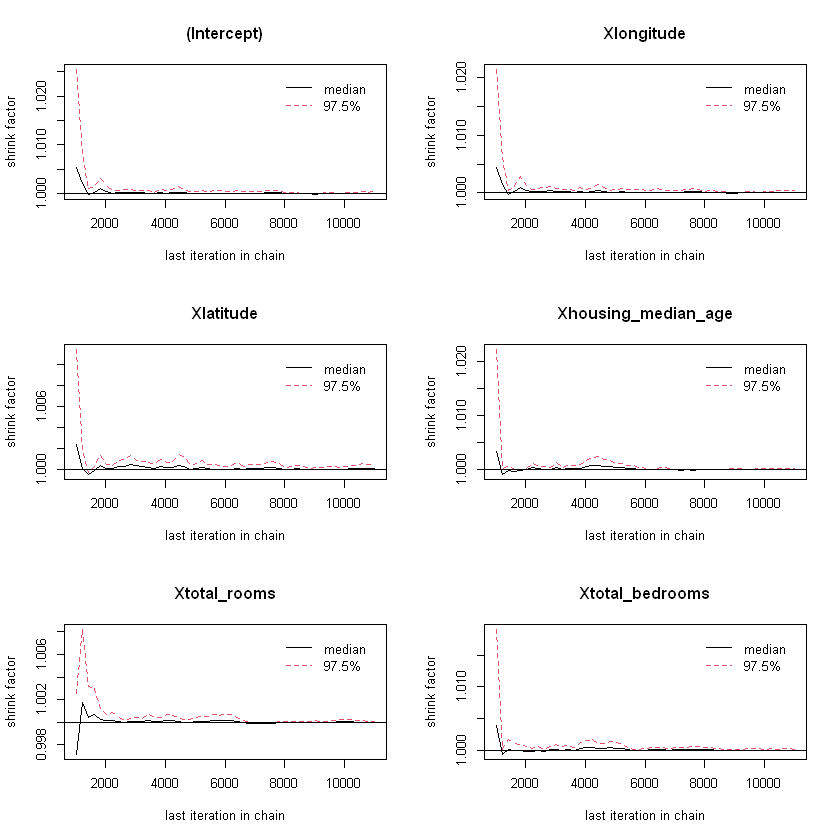

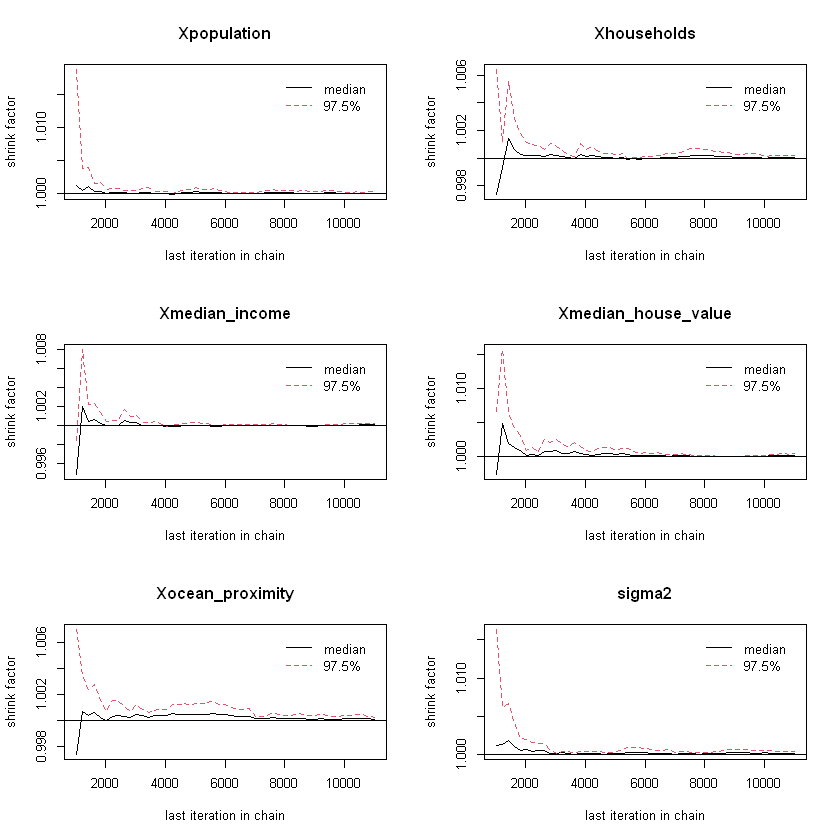

In [21]:
gelman.plot(postreg.list)

In [22]:
summary(postreg.list)



Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 5 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                          Mean        SD  Naive SE Time-series SE
(Intercept)          2.859e+00 1.664e-01 7.443e-04      7.387e-04
Xlongitude          -1.009e-01 1.904e-03 8.515e-06      8.413e-06
Xlatitude           -1.031e-01 1.784e-03 7.978e-06      7.839e-06
Xhousing_median_age -1.636e-03 1.041e-04 4.654e-07      4.632e-07
Xtotal_rooms         5.320e-06 1.889e-06 8.450e-09      8.444e-09
Xtotal_bedrooms      4.183e-07 1.654e-05 7.399e-08      7.371e-08
Xpopulation         -1.234e-05 2.651e-06 1.186e-08      1.168e-08
Xhouseholds          3.751e-05 1.790e-05 8.005e-08      8.005e-08
Xmedian_income       5.095e-03 1.048e-03 4.688e-06      4.670e-06
Xmedian_house_value  4.272e-06 1.661e-08 7.429e-11      7.421e-11
Xocean_proximity    -1.379e-02 8.719e-04 3.899e-06      3.911e-06
sigma2   

In [25]:
X <- as.matrix(housing[,c('longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity')])
V <- 1/100
model1 <- MCMCregress(ln_median_house_value  ~ X,data=housing,B0=V,marginal.likelihood="Laplace",  seed = 1234567)
summary(model1)



Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                          Mean        SD  Naive SE Time-series SE
(Intercept)          2.857e+00 1.648e-01 1.648e-03      1.648e-03
Xlongitude          -1.009e-01 1.883e-03 1.883e-05      1.883e-05
Xlatitude           -1.032e-01 1.765e-03 1.765e-05      1.765e-05
Xhousing_median_age -1.636e-03 1.042e-04 1.042e-06      1.042e-06
Xtotal_rooms         5.312e-06 1.892e-06 1.892e-08      1.856e-08
Xtotal_bedrooms      4.724e-07 1.659e-05 1.659e-07      1.635e-07
Xpopulation         -1.231e-05 2.651e-06 2.651e-08      2.651e-08
Xhouseholds          3.739e-05 1.784e-05 1.784e-07      1.784e-07
Xmedian_income       5.102e-03 1.044e-03 1.044e-05      1.024e-05
Xmedian_house_value  4.272e-06 1.673e-08 1.673e-10      1.673e-10
Xocean_proximity    -1.379e-02 8.760e-04 8.760e-06      8.760e-06
sigma2   

In [43]:
# library(BayesVarSel)

# # Standardize the data
# housing_std <- as.data.frame(scale(housing[, c('latitude', 'longitude', 'median_house_value','ln_median_house_value')]))

# # Perform Bayesian variable selection
# bvs1 <- Bvs(
#   formula = ln_median_house_value ~ latitude + longitude + median_house_value,
#   data = housing_std,
#   prior.betas = "gZellner",
#   n.keep = 5
# )

# # Print the results
# print(bvs1)



Info. . . .
Most complex model has 4 covariates
From those 1 is fixed and we should select from the remaining 3 
latitude, longitude, median_house_value
The problem has a total of 8 competing models
Of these, the  5 most probable (a posteriori) are kept
Working on the problem...please wait.


ERROR: Error in myfun(c(1, (2^p - 1)), method = method): A Bayes factor is infinite.


In [44]:
# summary(housing[, c('latitude', 'longitude', 'median_house_value', 'median_income', 'ln_median_house_value')])


    latitude       longitude      median_house_value median_income    
 Min.   :32.54   Min.   :-124.3   Min.   : 14999     Min.   : 0.4999  
 1st Qu.:33.93   1st Qu.:-121.8   1st Qu.:119500     1st Qu.: 2.5637  
 Median :34.26   Median :-118.5   Median :179700     Median : 3.5365  
 Mean   :35.63   Mean   :-119.6   Mean   :206864     Mean   : 3.8712  
 3rd Qu.:37.72   3rd Qu.:-118.0   3rd Qu.:264700     3rd Qu.: 4.7440  
 Max.   :41.95   Max.   :-114.3   Max.   :500001     Max.   :15.0001  
 ln_median_house_value
 Min.   : 9.616       
 1st Qu.:11.691       
 Median :12.099       
 Mean   :12.085       
 3rd Qu.:12.486       
 Max.   :13.122       

In [50]:
# bvs2 <- GibbsBvs(formula="ln_median_house_value ~ .",data=housing[, c('latitude', 'longitude', 'median_house_value', 'ln_median_house_value')],prior.betas="gZellner",
# prior.models="Constant", n.iter=10000, init.model="Full", n.burnin=100)

Info. . . .
Most complex model has 4 covariates
From those 1 are fixed and we should select from the remaining 3 
latitude, longitude, median_house_value
The problem has a total of 8 competing models
Of these, 10100 are sampled with replacement
Then, 10000 are kept and used to construct the summaries


Warning message in GibbsBvs(formula = "ln_median_house_value ~ .", data = housing[, :
"The number of variables is small enough to visit every model. Consider Bvs (or pBvs for its parallel version).
"


Working on the problem...please wait.


ERROR: Error in GibbsBvs(formula = "ln_median_house_value ~ .", data = housing[, : A Bayes factor is infinite.


In [19]:
# =========== SIMUALTIONS ===========